<a href="https://colab.research.google.com/github/zabihin/Block-3_Walmart_Sales/blob/main/Bloc_3_Uber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROJECTS Unsupervised Machine Learning



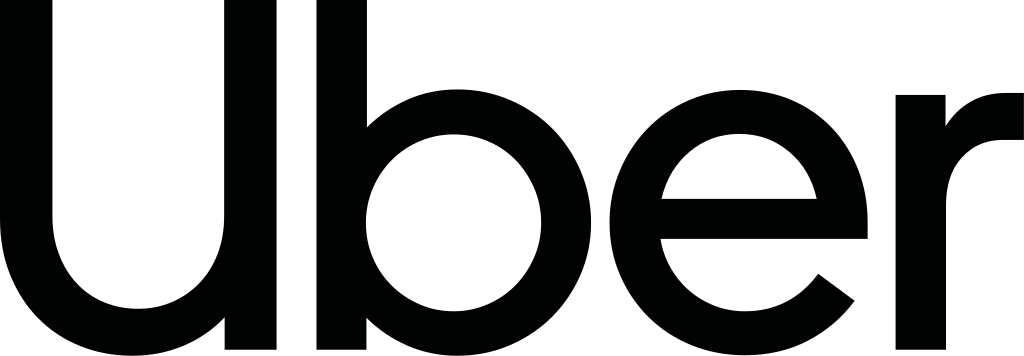



Project 🚧
One of the main pain point that Uber's team found is that sometimes drivers are not around when users need them. For example, a user might be in San Francisco's Financial District whereas Uber drivers are looking for customers in Castro.

(If you are not familiar with the bay area, check out Google Maps)

Eventhough both neighborhood are not that far away, users would still have to wait 10 to 15 minutes before being picked-up, which is too long. Uber's research shows that users accept to wait 5-7 minutes, otherwise they would cancel their ride.

Therefore, Uber's data team would like to work on a project where their app would recommend hot-zones in major cities to be in at any given time of day.

Goals 🎯
Uber already has data about pickups in major cities. Your objective is to create algorithms that will determine where are the hot-zones that drivers should be in. Therefore you will:

Create an algorithm to find hot zones
Visualize results on a nice dashboard

In [5]:
import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score




# 1- Data import and cleaning 

In [6]:
df_apr = pd.read_csv( "/content/drive/MyDrive/Colab Notebooks/uber-raw-data-apr14.csv")
df_may = pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/uber-raw-data-may14.csv') 
df_jun= pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/uber-raw-data-jun14.csv')
df_jul = pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/uber-raw-data-jul14.csv')
df_aug = pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/uber-raw-data-aug14.csv')
df_sep = pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/uber-raw-data-sep14.csv')
df_taxi = pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/taxi-zone-lookup.csv')


In [7]:
dataset= pd.concat([df_apr, df_may, df_jun, df_jul, df_aug, df_sep], ignore_index=True)


In [8]:
dataset['Date']=pd.to_datetime(dataset['Date/Time'], format = '%m/%d/%Y %H:%M:%S').round('60min')
dataset['month']= dataset['Date'].dt.month
dataset['day']= dataset['Date'].dt.day
dataset['day_of_week']= dataset['Date'].dt.weekday
dataset['hour']= dataset['Date'].dt.hour
dataset.columns

Index(['Date/Time', 'Lat', 'Lon', 'Base', 'Date', 'month', 'day',
       'day_of_week', 'hour'],
      dtype='object')

In [9]:
dataset.head()

,Date/Time,Lat,Lon,Base,Date,month,day,day_of_week,hour
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,2014-04-01 00:00:00,4,1,1,0
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,2014-04-01 00:00:00,4,1,1,0
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,2014-04-01 00:00:00,4,1,1,0
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,2014-04-01 00:00:00,4,1,1,0
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,2014-04-01 01:00:00,4,1,1,1


In [10]:
dataset=dataset.drop(columns=['Date/Time','Date'])


In [11]:
dataset.describe(include='all')

,Lat,Lon,Base,month,day,day_of_week,hour
count,4.534327e+06,4.534327e+06,4534327,4.534327e+06,4.534327e+06,4.534327e+06,4.534327e+06
unique,NaN,NaN,5,NaN,NaN,NaN,NaN
top,NaN,NaN,B02617,NaN,NaN,NaN,NaN
freq,NaN,NaN,1458853,NaN,NaN,NaN,NaN
mean,4.073926e+01,-7.397302e+01,NaN,6.829221e+00,1.594401e+01,2.976501e+00,1.430967e+01
std,3.994991e-02,5.726670e-02,NaN,1.703731e+00,8.745176e+00,1.883160e+00,6.140219e+00
min,3.965690e+01,-7.492900e+01,NaN,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,4.072110e+01,-7.399650e+01,NaN,5.000000e+00,9.000000e+00,1.000000e+00,1.000000e+01
50%,4.074220e+01,-7.398340e+01,NaN,7.000000e+00,1.600000e+01,3.000000e+00,1.600000e+01
75%,4.076100e+01,-7.396530e+01,NaN,8.000000e+00,2.300000e+01,5.000000e+00,1.900000e+01


#2-EDA

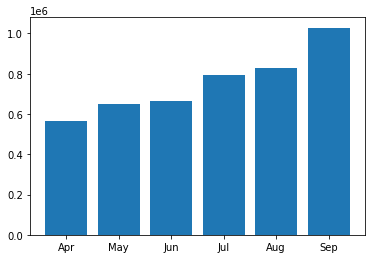

In [12]:
month=[4,5,6,7,8,9]
months=["Apr","May","Jun","Jul","Aug","Sep"]

stat_per_month=[len(dataset.loc[(dataset['month']==i)]) for i in month]
plt.bar(months,stat_per_month)
plt.show()

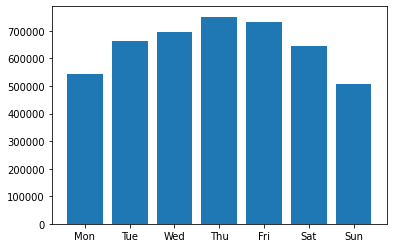

In [13]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

day=range(7)
stat_per_day=[dataset.loc[(dataset['day_of_week']==i)].count()[0] for i in day]
plt.bar(days,stat_per_day)
plt.show()

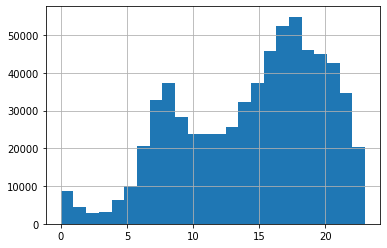

In [14]:
##histogram tue /h
dataset.loc[ (dataset['day_of_week']==1)].hour.hist(bins=24)


<Figure size 432x288 with 0 Axes>

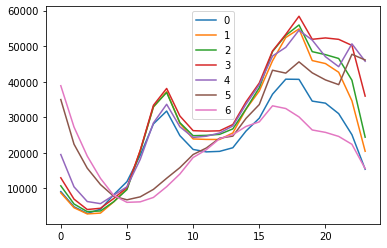

In [15]:
p=np.empty(shape=(24, 7), dtype=int)
for i in range(24):
  for j in range(7):
    p[i,j]=(len(dataset[(dataset['hour']==i) & (dataset['day_of_week']==j)]))
df=pd.DataFrame(p)

plt.figure();

df.plot()


#3-Sampling  and show data on map

In [16]:
sample_df = dataset.groupby("month").sample(n=10000, random_state=42)

In [17]:
fig = px.scatter_mapbox(sample_df, lat="Lat", lon="Lon",size_max=15, zoom=8, width=800, height=800)
fig.update_layout(mapbox_style="carto-positron")

fig.show(render='colab')

#4- Compare different model for clustering


###4-1 DBSCAN

In [18]:
df_test=sample_df[['Lat','Lon']]
scaler= StandardScaler()
db=DBSCAN(eps=0.2, min_samples=50,metric="euclidean", algorithm="brute")
df_s=scaler.fit_transform(df_test)
db.fit(df_s)
df_test['cluster']=db.fit_predict(df_s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
fig = px.scatter_mapbox(df_test, lat="Lat", lon="Lon",color='cluster',size_max=15, zoom=8, width=800, height=800)
fig.update_layout(mapbox_style="carto-positron")

fig.show()

###4-2 Kmeans

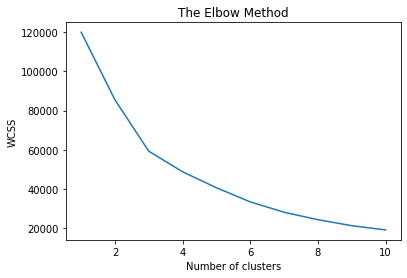

In [20]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_s)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [21]:
# Computer mean silhouette score
sil = []
k = []

for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 42)
    kmeans.fit(df_s)
    sil.append(silhouette_score(df_s, kmeans.predict(df_s)))
    k.append(i)

In [22]:
# Create a data frame 
cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)

# Create figure
fig = px.bar(data_frame=cluster_scores,  
             x=k, 
             y=cluster_scores.iloc[:, -1]
            )
fig.show(render='colab') 

In [23]:
kmeans = KMeans(n_clusters = 8, init = 'k-means++', random_state = 42)
scaler= StandardScaler()
df_test=sample_df[['Lat','Lon']]
df_s=scaler.fit_transform(df_test)
df_test['clusterkmeans'] = kmeans.fit_predict(df_s)
center=pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),columns=["Lat","Lon"])
center["size"]=10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
fig = px.scatter_mapbox(df_test, lat="Lat", lon="Lon",color='clusterkmeans',size_max=15, zoom=8, width=800, height=800)
fig.update_layout(mapbox_style="carto-positron")
fig2= px.scatter_mapbox(center,lat="Lat", lon="Lon",size="size", zoom=8, width=800, height=800)
fig.add_trace(fig2.data[0])
fig.show(render='colab')

در فاصله دریا رو نمی بینه 


#5- Clustering base on day and hour

In [46]:
def cluster_day_hour(dataset,day,hour):
  df=dataset.loc[(dataset['hour']==hour)&((sample_df['day_of_week']==day)) ]
  df=df[['Lat','Lon']]
  scaler= StandardScaler()
  df_s=scaler.fit_transform(df)
  kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
  df['clusterkmeans'] = kmeans.fit_predict(df_s)
  center=scaler.inverse_transform(kmeans.cluster_centers_)
  
  return df,center


In [47]:
df_sat_0, center =cluster_day_hour(sample_df,6,0)
center_k=pd.DataFrame(center,columns=["Lat","Lon"])
center_k["size"]=10

In [48]:
fig = px.scatter_mapbox(df_sat_0, lat="Lat", lon="Lon",color='clusterkmeans',size_max=15, zoom=8, width=800, height=800)
fig.update_layout(mapbox_style="carto-positron")
fig2= px.scatter_mapbox(center_k,lat="Lat", lon="Lon",size="size")
fig.add_trace(fig2.data[0])
fig.show()

In [49]:
centers=pd.DataFrame(columns=['Day','Hour','Center_lat','Center_lon'])

for i in range(7):
  for j in range(24):
    _ , center =cluster_day_hour(sample_df,i,j)
    row0=pd.DataFrame([{'Day':i,'Hour':j,'Center_lat':center[0][0],'Center_lon':center[0][1]}])
    row1=pd.DataFrame([{'Day':i,'Hour':j,'Center_lat':center[1][0],'Center_lon':center[1][1]}])
    row2=pd.DataFrame([{'Day':i,'Hour':j,'Center_lat':center[2][0],'Center_lon':center[2][1]}])
    row3=pd.DataFrame([{'Day':i,'Hour':j,'Center_lat':center[3][0],'Center_lon':center[3][1]}])

    centers=pd.concat([centers,row0,row1,row2,row3],ignore_index=True)


In [50]:
centers

,Day,Hour,Center_lat,Center_lon
0,0,0,40.732206,-73.982970
1,0,0,40.642424,-73.793762
2,0,0,41.056900,-73.715300
3,0,0,40.796081,-73.913769
4,0,1,40.666814,-73.909157
...,...,...,...,...
667,6,22,40.783272,-73.894059
668,6,23,40.792606,-73.910079
669,6,23,40.731563,-73.982677
670,6,23,40.643333,-73.804650


In [51]:
fig = px.scatter_mapbox(centers, lat="Center_lat", lon="Center_lon",
            animation_frame = 'Day', animation_group = 'Hour', 
            color="Hour"
            )
fig.update_layout(mapbox_style="carto-positron")
fig.show()
